# Regression using Feedforward Networks

The goal for this notebook is to predict how long will it take to do a recipe based on the [Recipe NLG Dataset](https://recipenlg.cs.put.poznan.pl/)

## ⬇️ Imports

In [ ]:
import pandas as pd
import numpy as np
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

ps = PorterStemmer()

## 🛠️ Preprocessing
### Downloading the dataset

If not already done, use this [notebook](../../preprocessing/preprocessing.ipynb) to download the dataset in your local directory.

In [2]:
data = pd.read_csv('../../../data/processed/preprocessed_recipe.csv')

In [9]:
data.head()

,id,name,minutes,n_steps,description,n_ingredients,steps_string_standardize,ingredients_text,tags_text,calories,total_fat,sugar,sodium,protein,saturated_fat,carbohydrates
0,137739,arriba baked squash mexican,55,11,autumn is my favorite time of year to cook! th...,7,make a choic and proceed with recip depend on ...,"['winter squash', 'mexican seasoning', 'mixed ...","['60-minutes-or-less', 'time-to-make', 'course...",51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,31490,breakfast pizza,30,9,this recipe calls for the crust to be prebaked...,6,preheat oven to 103.33 celsius °c press dough ...,"['prepared pizza crust', 'sausage patty', 'egg...","['30-minutes-or-less', 'time-to-make', 'course...",173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,112140,chili,130,6,this modified version of 'mom's' chili was a h...,13,brown ground beef in larg pot add chop onion t...,"['ground beef', 'yellow onions', 'diced tomato...","['time-to-make', 'course', 'preparation', 'mai...",269.8,22.0,32.0,48.0,39.0,27.0,5.0
3,59389,alouette potato,45,11,"this is a super easy, great tasting, make ahea...",11,place potato in a larg pot of lightli salt wat...,"['spreadable cheese with garlic and herbs', 'n...","['60-minutes-or-less', 'time-to-make', 'course...",368.1,17.0,10.0,2.0,14.0,8.0,20.0
4,44061,amish tomato ketchup canning,190,5,my dh's amish mother raised him on this recipe...,8,"mix all ingredients& boil for 2 30.0 minute , ...","['tomato juice', 'apple cider vinegar', 'sugar...","['weeknight', 'time-to-make', 'course', 'main-...",352.9,1.0,337.0,23.0,3.0,0.0,28.0


In [3]:
steps_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
steps_features = steps_vectorizer.fit_transform(data["steps_string_standardize"])

ingredients_vectorizer = TfidfVectorizer(max_features=300, stop_words='english')
ingredients_features = ingredients_vectorizer.fit_transform(data["ingredients_text"])

tags_vectorizer = TfidfVectorizer(max_features=300, stop_words='english')
tags_features = tags_vectorizer.fit_transform(data["tags_text"])

In [4]:
#numerical_features = data[['n_steps', 'n_ingredients', 'token_count', 'avg_token_length', 'calories', 'total_fat', 'sugar', 'sodium', 'saturated_fat', 'carbohydrates']].values
numerical_features = data[['n_steps', 'n_ingredients', 'calories', 'total_fat', 'sugar', 'sodium', 'saturated_fat', 'carbohydrates']].values

feature_matrices = [steps_features.toarray(), ingredients_features.toarray(),
                    tags_features.toarray(),
                   numerical_features]

In [5]:
X = np.hstack(feature_matrices)
y = data["minutes"].values

## Training our model

In [9]:
X_train, X_test, y_train, y_test, X_train_indices, X_test_indices = train_test_split(
    X, y, data.index, test_size=0.2, random_state=42
)
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

def create_model():
        model = Sequential([
        # Input layer
        # l2 => to prevent overfitting
        Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        # Hidden layers
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        # Output layer (single neuron for regression)
        Dense(1)
        ])
        model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mean_squared_error'  # MSE for regression
        )
        return model

model = create_model()

early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
)

history = model.fit(
        X_train_scaled, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 1883.7659 - val_loss: 452.9340 - learning_rate: 0.0010
Epoch 2/100
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 580.8558 - val_loss: 423.6923 - learning_rate: 0.0010
Epoch 3/100
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 517.4100 - val_loss: 386.7677 - learning_rate: 0.0010
Epoch 4/100
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 482.7661 - val_loss: 380.5625 - learning_rate: 0.0010
Epoch 5/100
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 447.3882 - val_loss: 374.0631 - learning_rate: 0.0010
Epoch 6/100
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 432.4598 - val_loss: 370.4406 - learning_rate: 0.0010
Epoch 7/100
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 414.6584 - val_loss: 385.2639 - learning_rate: 0.0010
Epoch 8/100
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 404.4454 - val_loss: 387.9988 - learning_rate: 0.0010
Epoch 9/100
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 

In [ ]:

from sklearn.inspection import permutation_importance

# Wrap the Keras model for use with scikit-learn
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Compute permutation importance
result = permutation_importance(
    estimator=None,  # We'll use a custom predict function
    X=X_test_scaled,
    y=y_test,
    scoring='neg_mean_absolute_error',
    n_repeats=5,
    random_state=42,
    n_jobs=1,
    estimator_predict=keras_predict  # Custom predict function
)

# Feature names
feature_names = (
    [f"step_{i}" for i in range(steps_features.shape[1])] +
    [f"ingredient_{i}" for i in range(ingredients_features.shape[1])] +
    [f"tag_{i}" for i in range(tags_features.shape[1])] +
    list(data[['n_steps', 'n_ingredients', 'calories', 'total_fat', 'sugar', 'sodium', 'saturated_fat', 'carbohydrates']].columns)
)

# Sort and plot
importances = result.importances_mean
indices = np.argsort(importances)[::-1][:20]  # Top 20 features

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices][::-1], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices][::-1])
plt.xlabel("Permutation Importance (MAE decrease)")
plt.title("Top 20 Feature Importances")
plt.show()

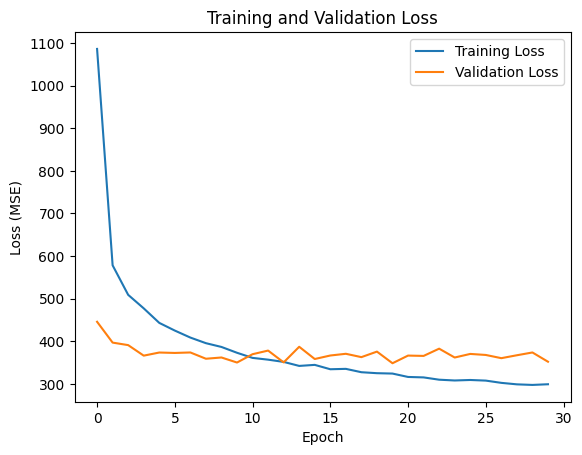

In [18]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

## Defining Metrics and small tests


- MAE :
    - Represents how much is it off on average
    - Ex : You make predictions that are off by 15 minutes on average

- R^2 :
    - Ranges from negative to 1
    - The closer it is to 1 the better it is
    - Under 0 it performs worse then random

In [ ]:
def get_metrics(y_test, y_pred):
    # MAE
    print("MAE:", mean_absolute_error(y_test, y_pred))

    # R²
    print("R²:", r2_score(y_test, y_pred))

def get_mae_by_recipe_length(y_true, y_pred, threshold_long=60, threshold_fast=30):

    # Create masks for fast and long recipes
    fast_recipes_mask = y_true <= threshold_fast
    long_recipes_mask = y_true > threshold_long
    
    # Calculate MAE for each category
    mae_fast = mean_absolute_error(y_true[fast_recipes_mask], y_pred[fast_recipes_mask]) if any(fast_recipes_mask) else None
    mae_long = mean_absolute_error(y_true[long_recipes_mask], y_pred[long_recipes_mask]) if any(long_recipes_mask) else None
    
    print("MAE_fast_recipes"+ mae_fast)
    print("MAE_long_recipes"+ mae_long)
    

y_pred = model.predict(X_test_scaled).flatten()
get_metrics(y_test, y_pred)
get_mae_by_recipe_length(y_test, y_pred)

1355/1355 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
MAE: 9.68120288848877
R²: 0.8351460099220276


In [16]:
#original_row = data.loc[X_test_indices[33]]
# display(original_row)
print("y_test[33]:", y_test[33])
print("y_pred_lr[33]:", y_pred[33])


y_test[33]: 30
y_pred_lr[33]: 22.491306
